In [1]:
# python imports
import os
import time
import functools

import numpy as np
from scipy import stats
from scipy.stats import uniform, norm, t as tdist, ttest_ind


In [2]:
# setup graphs
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib import rc

plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100;

# numpy print format
np.set_printoptions(linewidth=120, precision=4, suppress=False, formatter={'float': '{:5.3e}'.format})

In [3]:
# local imports
import util.tests as tests
import util.dwdb_reader as io
import util.func as f


DpawsTools not found. Fall back to scipy


In [29]:
small_value = 1e-300

PROJECT_ROOT_DIR=os.getcwd()
tracenum = 50000
step = 10000
sample_start = 120 # 30  100    # 40
sample_end =   130 # 50  500    # 180
rlen = sample_end - sample_start

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(IMAGES_PATH): os.makedirs(IMAGES_PATH)

LOG_DIR = os.path.join(PROJECT_ROOT_DIR, "log")
if not os.path.exists(LOG_DIR): os.makedirs(LOG_DIR)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load traces and predictions

In [30]:
print("Reading traces")
# dsr = io.dwdb_reader(r'DPAD_FvR.Traces/RawTraces.dwdb', r'DPAD_FvR.Traces')
# dsr = io.dwdb_reader(r'DPAD_AES2.Traces/RawTraces_new.dwdb', r'DPAD_AES2.Traces')
dsr = io.dwdb_reader(r'RawTraces_new.dwdb', r'.')
data_batch, meta_batch = dsr.read_batch(tracenum, sample_start, sample_end)
print("Done")

print("Processing data and meta")
# converting data to numpy matrix
data_np = np.asarray(data_batch)

#processing of classifiers
meta_prep = [m['other'].split() for m in meta_batch]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers_np = np.asarray(classifiers)

print("Done")

data_np.shape, classifiers_np.shape

Reading traces
Done
Processing data and meta
Done


((50000L, 10L), (50000L,))

## Sanity check. Make sure it leaks

In [35]:
atrace = data_np[0] / 100 # scale it to ttest range
tt = tests.fvr_ttest(data_np, classifiers_np)
atrace.shape, tt.shape

((10L,), (10L,))

<IPython.core.display.Javascript object>


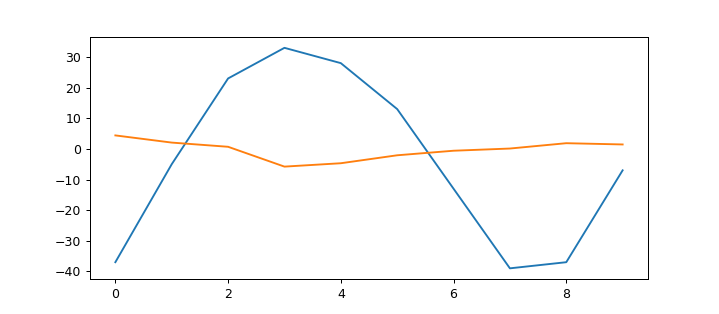

In [36]:
fig = plt.figure()
plt.plot(atrace)
plt.plot(tt)
plt.show()

## Evolution

In [37]:
tstat_evo = []
xx = np.arange(step, tracenum+1, step)
for x in xx:
#     print("Calc ttest for {} traces".format(x))
    tt = tests.fvr_ttest(data_np[:x], classifiers_np[:x])
    tstat_evo.append(tt)
tstat_evo = np.array(tstat_evo)
tstat_evo = np.abs(tstat_evo) # comment out for intermediates
tstat_evo.shape

(5L, 10L)

<IPython.core.display.Javascript object>


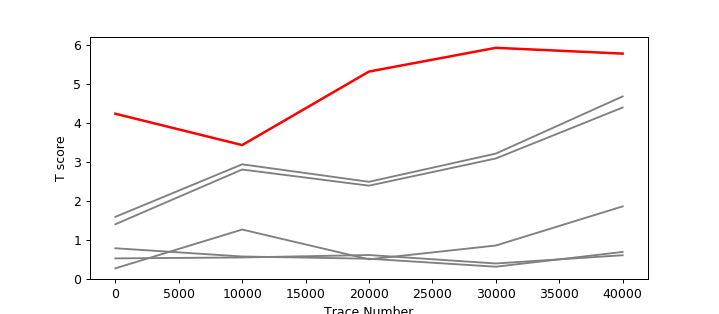

Max leak at point: 3


In [38]:
step_num, pt_num = np.shape(tstat_evo)

x_axis = np.arange(step_num) * step

fig = plt.figure()
plt.ylabel('T score')
plt.xlabel('Trace Number')

# Plot leak history for each 2th point 
for j in range(0, pt_num, 2):
    plk = tstat_evo.T[j]
    plt.plot(x_axis, plk, linewidth=1.5, linestyle='-', color = 'grey', zorder = j)

# Max leak point
ml_pt = np.argmax(np.abs(tstat_evo[-1, :])) # max leak point
plt.plot(x_axis, tstat_evo[:, ml_pt], linewidth=2, linestyle='-', color = 'r', zorder=255)

plt.show()

max_leak_pt = ml_pt # store for later
print("Max leak at point: {}".format(max_leak_pt))

## Bootstrapping

In [40]:
boots = 205
boot_step = step
upper_bnd = tracenum
t_full_per_step = []
tp_full_per_step = []
tplog_full_per_step = []
for rangenum in range(boot_step, upper_bnd+1, boot_step):
    print("attacking on {} traces".format(rangenum))
    start = time.time()
    t_full, tp_full = [], []
    boot_idxs = np.random.randint(rangenum, size=(boots, rangenum))
    for bi in boot_idxs:
        # for all pts do the following:
        tt_per_boot = tests.fvr_ttest(data_np[bi], classifiers_np[bi]) # calc tt
        n = len(data_np[bi])
        t_full.append(tt_per_boot)                         # store tt
        tpv = tdist.sf(tt_per_boot, n)                     # convert tt to pv and store
        tp_full.append(tpv)                                
    t_full_per_step.append(t_full)
    tp_full_per_step.append(tp_full)
    print("{} boots are done in {}".format(boots, time.time() - start))
t_full_per_step = np.array(t_full_per_step)
tp_full_per_step = np.array(tp_full_per_step)
# tp_full_per_step[np.where(np.isnan(tp_full_per_step))] = small_value
# tp_full_per_step[np.where(tp_full_per_step < small_value)] = small_value
# tplog_full_per_step = -1.0 * np.log10(tp_full_per_step)

attacking on 10000 traces
205 boots are done in 0.575000047684
attacking on 20000 traces
205 boots are done in 1.27399992943
attacking on 30000 traces
205 boots are done in 2.47899985313
attacking on 40000 traces
205 boots are done in 3.52700018883
attacking on 50000 traces
205 boots are done in 4.70999979973


In [25]:
# Find out whether it follows the uniform distribution
ld_stat = stats.uniform
ld_cdf = ld_stat().cdf
ksp_per_step = np.zeros_like(tp_full_per_step[:,1])

for s, bps in enumerate(tp_full_per_step):          # step
    bpsr = bps.T                                    # -> (pt, boot)
    start = time.time()
    print('{}: Step {} ...'.format(bpsr.shape, s))
    for i, ptbt in enumerate(bpsr):
        d, kpv = f.kstest(ptbt, ld_cdf)
        ksp_per_step[s, i] = kpv
    print("Done in {}".format(time.time() - start))


(20L, 205L): Step 0 ...
Done in 0.0119998455048
(20L, 205L): Step 1 ...
Done in 0.0090000629425
(20L, 205L): Step 2 ...
Done in 0.00899982452393
(20L, 205L): Step 3 ...
Done in 0.00999999046326
(20L, 205L): Step 4 ...
Done in 0.0090000629425


# Bootstrapping vizualization

<IPython.core.display.Javascript object>


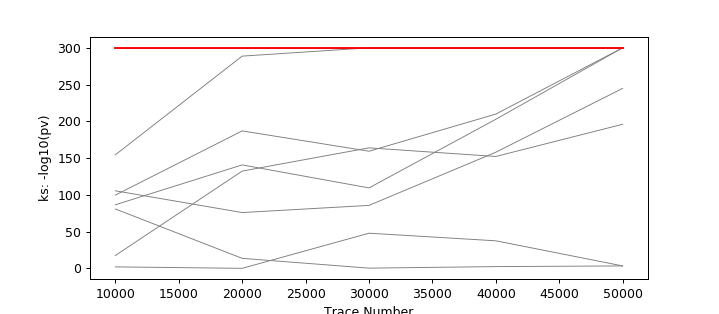

In [41]:
mpi =  max_leak_pt # 15

# Visualization (prepare data)
plot_evo = ksp_per_step.T.copy()
plot_evo[np.where(plot_evo < small_value)] = small_value
pt_num, step_num = np.shape(plot_evo)

x_axis = (np.arange(step_num) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('ks: -log10(pv)')

# Plot each 2nd point
for j in range(0, pt_num, 2):
    kspl = -np.log10(plot_evo[j])
    plt.plot(x_axis, kspl, linewidth=0.75, color = 'grey', zorder = j)

# and a special one
maxkslpv = -np.log10(plot_evo[mpi])
plt.plot(x_axis, maxkslpv, linewidth=1.5, color = 'r', zorder=255)

plt.show()
# plot_evo.shape, x_axis.shape

## Debugging distributions for kstest

<IPython.core.display.Javascript object>


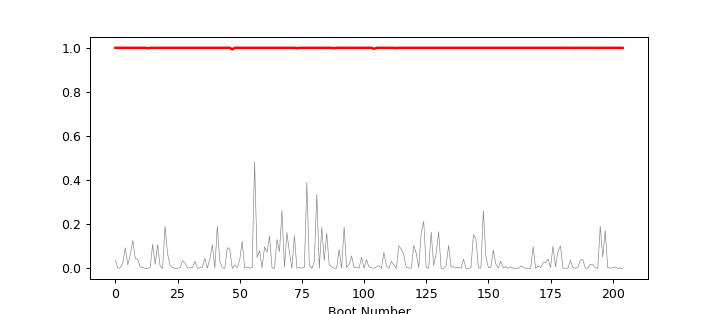

In [43]:

mpi = max_leak_pt # 6 178
si = 2

# bpvs = t_full_per_step[si].T  # t
bpvs = tp_full_per_step[si].T   # t-pv

kpvs = []
leak_dist = stats.uniform
# leak_dist = stats.norm
for j in range(0, len(bpvs)):
    bp = bpvs[j]
    d, pv = f.kstest(bp, leak_dist().cdf)
    l, s = leak_dist.fit(bp)      # loc and scale of the dist at the point
    leaking = pv < 0.05           # 3 sigma assurance the point is leaking (non uniform)
    kpvs.append([d, pv, l, s, leaking])
d, pv = f.kstest(bpvs[mpi], leak_dist().cdf)
l, s = leak_dist.fit(bpvs[mpi])  # loc and scale of the dist at the max leak point
leaking = pv < 0.05
kpvs.append([d, pv, l, s, leaking])

# print("d, pv, l, s, leaking")
# print(np.array(kpvs))
    
# norm_cdf = norm(loc=0, scale=1).cdf
# dt, pv  = stats.kstest(bpvs, norm_cdf)

fig = plt.figure()
plt.xlabel('Boot Number')
for j in range(0, len(bpvs), 20):
    plt.plot(bpvs[j], color = 'grey', linewidth=0.5, zorder = j)

plt.plot(bpvs[mpi], color = 'r', linewidth=2, zorder=255)
plt.show()

## Debugging at some boot

In [ ]:
%%script false    # This line is to skip this cell as a whole in the real run. Comment to debug a boot step
# rp_full_per_step = []  # rpv
# t_full_per_step = []   # t
# tp_full_per_step = []  # tpv

pb = 0
bootidx = 15

pb = 0
pi = 19 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0

plot_evo = t_full_per_step[:,bootidx,:,pi].reshape(-1, 3, 256)

x_axis = (np.arange(len(plot_evo)) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('T score')

hw_num = plot_evo.shape[2]
for j in range(0, hw_num, 4):
    mtt = plot_evo[:, byte_idx[pb], j]
    plt.plot(x_axis, mtt, linewidth=0.5, color = 'grey', zorder = j)
plt.plot(x_axis, plot_evo[:, byte_idx[pb], key_idx[pb]], linewidth=1, color = 'r', zorder=255)

plt.show()


## Getting familiar with tests 

In [ ]:
ud = uniform(loc=0, scale=1)
for i in range(3):
    udrv = ud.rvs(size=1000)
    dk, kpv = stats.kstest(udrv, 'uniform') # H0 - data is uniform
    non_uniform = kpv < 0.05
    print(dk, kpv, non_uniform)

In [ ]:
x_100 = norm.rvs(loc=10, scale=1, size=100)
nd = norm(loc=0, scale=1)
for i in range(3):
    ndrv = nd.rvs(size=100)
    dn, npv = stats.kstest(ndrv, 'norm') # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

In [ ]:
nd_cdf = norm(loc=10, scale=1).cdf
for i in range(3):
    ndrv = norm.rvs(loc=10, scale=1, size=100)
    dn, npv = stats.kstest(ndrv, nd_cdf) # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

In [ ]:
n = 100
a = np.random.random(size=(n, 2)) * 10.0
b = np.random.randint(0, 10, size=(n, 1), dtype=np.uint8)
a[:,0] += b[:,0] / 2.0

bincor = DpawsTools.Bincor(2, 1)
bincor.process(a, b)
rr = np.vstack(bincor.correlation())
pr = np.vstack([r2pv(r, n) for r in rr.copy()])
tt = np.vstack([DpawsTools.FisherTransformation(n, r) for r in rr.copy()])
tt2 = [DpawsTools.FisherTransformation(bincor.count(), _cc) for _c in [rr.copy()] for _cc in _c]
pt = np.vstack([tdist.sf(t1, n) for t1 in tt])

print(rr)
print(tt)
print(tt2)
print(pr) # p-val from r
print(pt) # p-val from t-stat
